In [1]:
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, UpSampling2D, Conv2D, Conv2DTranspose, Reshape, Input
from tensorflow.keras import optimizers
from efficientnet.tfkeras import EfficientNetB2, preprocess_input
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import cv2
import MVTecAD_loaddata as mv
import pandas as pd

res = []
def mahalanobis_kernel(X1, X2):
    m, n = X1.shape
    o, p = X2.shape
    K = np.zeros((m,o))
    # 共分散行列の計算
    S = np.cov(X1.T)
    S = S + 1e-3 * np.eye(n)
    # 共分散行列の逆行列の計算
    S_inv = np.linalg.inv(S)
    # マハラノビスカーネル
    for i in range(m):
        for j in range(o):
            K[i,j] = np.exp(-1*(X1[i,:]-X2[j,:])@S_inv@((X1[i,:]-X2[j,:]).T))
    return K

def OCSVM(X, x_test, y, y_test):
#     tuned_parameters = [
#         {'nu': [2**-3, 2**-4, 2**-5, 2**-6, 2**-7], 'kernel': ['precomputed']},
#     ]
    tuned_parameters = [
        {'nu': [2**-3, 2**-4, 2**-5, 2**-6, 2**-7], 'kernel': ['rbf'], 'gamma': [10**-3, 10**-4, 10**-5, 10**-6, 10**-7]},
    ]
    score = 'accuracy'
    clf = GridSearchCV(
        OneClassSVM(),
        tuned_parameters,
        cv=5,
        scoring=score)
#         scoring='%s_weighted' % score )
          
    clf.fit(X, y)
          
    a = clf.decision_function(x_test)
    b = clf.predict(x_test)
    r1 = roc_auc_score(y_test,a)
    r2 = f1_score(y_test,b)
    r3 = accuracy_score(y_test,b)
    print('roc_auc : ',r1)
    print('f1_score : ', r2)
    print('accuracy_score : ', r3)
    print('best_params : ', clf.best_params_)
    result = [r1,r2,r3]
    return result

def model_train(X_train, X_test):
    input_shape = (256, 256, 3)
    inputs = Input(input_shape)

    base_model = EfficientNetB2(include_top=False, weights='imagenet', pooling='avg')(inputs)
    outputs = Reshape((1,1,1408))(base_model)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')
    f_tr = model.predict(X_train, verbose=0)
    f_ts = model.predict(X_test, verbose=0)
    
    x_tr = np.reshape(f_tr, (f_tr.shape[0], -1))
    x_ts = np.reshape(f_ts, (f_ts.shape[0], -1))
    
    incov_train = np.linalg.inv(np.cov(x_tr.T))
    incov_test = np.linalg.inv(np.cov(x_ts.T))
    
    x_tr = (x_tr@incov_train)
    x_ts = (x_ts@incov_test)
    
    x_tr = x_tr/(np.max(x_tr))
    x_ts = x_ts/(np.max(x_ts))
    
    return x_tr, x_ts

In [2]:
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.7590361445783133
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


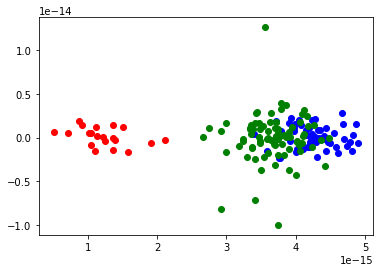

In [7]:
from sklearn.decomposition import PCA

x_tg, x_te = model_train(X_test_good, X_test_error)

# pca = PCA()
# pca.fit(x_train)
# f_tr = pca.transform(x_train)
# f_tr = f_tr[:,:2]

pca.fit(x_te)
f_te = pca.transform(x_te)
f_te = f_te[:,:2]

pca.fit(x_tg)
f_tg = pca.transform(x_tg)
f_tg = f_tg[:,:2]

# pca.fit(x_test)
# f_ts = pca.transform(x_test)
# f_ts = f_ts[:,:2]
plt.scatter(f_tg[:,0], f_tg[:,1], color='r')
plt.scatter(f_te[:,0], f_te[:,1], color='b')
plt.scatter(f_ts[:,0], f_ts[:,1], color='g')

In [26]:
c = OneClassSVM(nu=0.1)
c.fit(x_train)
sv = c.support_vectors_
n = c.support_

In [38]:
f = f_tr[n,:]
f.shape

(21, 209)

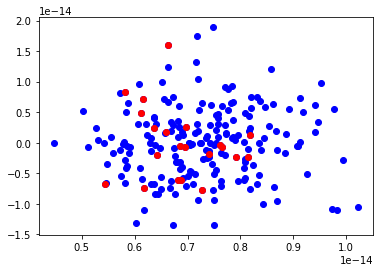

In [39]:
pca.fit(x_train)
f_tr = pca.transform(x_train)
# pca.fit(f)
# f = pca.transform(f)
plt.scatter(f_tr[:,0], f_tr[:,1], color='b')
plt.scatter(f[:,0], f[:,1], color='r')

In [3]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.4222035323801514
f1_score :  0.0
accuracy_score :  0.5857142857142857
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [4]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.8257575757575758
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [5]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.7941176470588235
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [6]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.7307692307692307
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [7]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.6363636363636364
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [8]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.425101902173913
f1_score :  0.0
accuracy_score :  0.7419354838709677
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [9]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.808695652173913
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [10]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.844311377245509
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [11]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5014347202295553
f1_score :  0.0
accuracy_score :  0.74375
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [13]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5957792207792209
f1_score :  0.0
accuracy_score :  0.717948717948718
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [14]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.7142857142857143
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [15]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5375
f1_score :  0.0
accuracy_score :  0.4
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [16]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.4473684210526315
f1_score :  0.0
accuracy_score :  0.759493670886076
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [17]:
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = model_train(X_train, X_test)
result = OCSVM(x_train, x_test, y_tr, y_ts)
res.append(result)

roc_auc :  0.5
f1_score :  0.0
accuracy_score :  0.7880794701986755
best_params :  {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.125}


In [18]:
df = pd.DataFrame(res)
df.to_csv('DCAEOCSVM_Nop_MAH.csv')